The first cell imports libraries. This code uses Tensorflow version 0.9. If Tensorflow version is not the same, the code may not work.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os
import random
import time
from six.moves import cPickle

import numpy as np
import tensorflow as tf

from tensorflow.models.rnn.ptb import reader

The next part is function definitions to read and prepare data for learning.

In [2]:
def _read_words(filename):
    "Given a filename, returns a list of words, which are separated by a space."
    with tf.gfile.GFile(filename, "r") as f:
        return f.read().decode("utf-8").replace("\n", " ").split()

def _build_vocab(data):
    "Given data (a list of words), returns a sorted words list and dictionary of word/frequency pairs."
    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

def _file_to_word_ids(data, word_to_id):
    
    return [word_to_id[word] for word in data if word in word_to_id]

Config class defines configuration parameters.

In [4]:
class Config():
    learning_rate = 1.0
    max_grad_norm = 5
    num_layers = 2
    num_steps = 20
    hidden_size = 200
    max_epoch = 5
    max_max_epoch = 15
    #max_max_epoch = 1    # for debugging
    keep_prob = 1.0
    lr_decay = 0.5
    batch_size = 20
    vocab_size = 100000

These two functions are utilities to fix a variable scope problem on tensorflow.

In [5]:
def get_scope_variable(scope_name, var, shape=None):
    with tf.variable_scope(scope_name) as scope:
        try:
            v = tf.get_variable(var, shape)
        except ValueError:
            scope.reuse_variables()
            v = tf.get_variable(var)
    return v

def cell_with_retry(cell, inputs, time_step, state):
    try:
        (cell_output, state) = cell(inputs[:, time_step, :], state)
    except ValueError:
        tf.get_variable_scope().reuse_variables()
        (cell_output, state) = cell(inputs[:, time_step, :], state)
    return (cell_output, state)

This is a model definition. The model uses LSTM (long short term memory) cell, which is stacked up by config.num_layers.

In [6]:
class Model():
    def __init__(self, is_training, config):
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        size = config.hidden_size
        vocab_size = config.vocab_size
        
        self._input_data = tf.placeholder(tf.int32, [batch_size, num_steps])
        self._targets = tf.placeholder(tf.int32, [batch_size, num_steps])

        # gets LSTM cell
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0)
        # dropout setting, increase/decrease number of neurons
        if is_training and config.keep_prob < 1:
            lstm_cell = tf.nn.rnn_cell.DropoutWrapper(
                lstm_cell, output_keep_prob=config.keep_prob)
        # stacks up cells
        self._cell = cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.num_layers)

        self._initial_state = cell.zero_state(batch_size, tf.float32)
        
        outputs = []
        state = self._initial_state
        
        # softmax of weights
        softmax_w = get_scope_variable("RNN", "softmax_w", [size, vocab_size])
        # softmax of bias
        softmax_b = get_scope_variable("RNN", "softmax_b", [vocab_size])
        
        # looks up embeddings and gets input
        with tf.device("/cpu:0"):
            embedding = get_scope_variable("RNN", "embedding", [vocab_size, size])
            inputs = tf.nn.embedding_lookup(embedding, self._input_data)

        with tf.variable_scope("RNN"):
            for time_step in range(num_steps):
                if time_step > 0: tf.get_variable_scope().reuse_variables()
                # updates a state and computes outputs
                (cell_output, state) = cell_with_retry(cell, inputs, time_step, state)
                outputs.append(cell_output)
            

        # calculates dropouts.
        if is_training and config.keep_prob < 1:
            # the second argument is probablitiy, keep_prob.
            # outputs will be scaled by 1/keep_prob.
            inputs = tf.nn.dropout(inputs, config.keep_prob)

        output = tf.reshape(tf.concat(1, outputs), [-1, size])
        
        # caclulates y = Wx + b (score y is called logits)
        logits = tf.matmul(output, softmax_w) + softmax_b
        # computes softmax cross entropy loss of batch_size
        loss = tf.nn.seq2seq.sequence_loss_by_example(
            [logits],
            [tf.reshape(self._targets, [-1])],
            [tf.ones([batch_size * num_steps])])
        # gets scalar value of normalized loss
        self._cost = cost = tf.reduce_sum(loss) / batch_size
        self._final_state = state
        self._probs = tf.nn.softmax(logits)
        
        if not is_training:
            return

        self._lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),
                                          config.max_grad_norm)
        # optimazation
        optimizer = tf.train.GradientDescentOptimizer(self.lr)
        self._train_op = optimizer.apply_gradients(zip(grads, tvars))
        
        # updates embeddings. computes similarity based on cosine distance
        norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
        self._normalized_embeddings = embedding / norm
        
        # saves cost in a sumarry for visualization
        tf.scalar_summary("cost", cost)

    def assign_lr(self, session, lr_value):
        session.run(tf.assign(self.lr, lr_value))

    @property
    def input_data(self):
        return self._input_data

    @property
    def targets(self):
        return self._targets

    @property
    def initial_state(self):
        return self._initial_state

    @property
    def cost(self):
        return self._cost

    @property
    def cell(self):
        return self._cell
    
    @property
    def final_state(self):
        return self._final_state
    
    @property
    def probs(self):
        return self._probs

    @property
    def lr(self):
        return self._lr

    @property
    def train_op(self):
        return self._train_op
    
    # sampling function to generate a sequence of words
    def sample(self, session, words, vocab, num=200, prime=' ', sampling_type=1):
        state = session.run(self.cell.zero_state(1, tf.float32))
        if not len(prime) or prime == " ":
            prime  = random.choice(list(vocab.keys()))    
        print (prime)
        for word in prime.split()[:-1]:
            print (word)
            x = np.zeros((1, 1))
            x[0, 0] = vocab.get(word,0)
            feed = {self.input_data: x, self.initial_state:state}
            [state] = session.run([self.final_state], feed)
         
        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        word = prime.split()[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab.get(word,0)
            feed = {self.input_data: x, self.initial_state:state}
            [probs, state] = session.run([self.probs, self.final_state], feed)
            p = probs[0]

            if sampling_type == 0:
                sample = np.argmax(p)
            else: # sampling_type == 1 default:
                sample = weighted_pick(p)

            pred = words[sample]
            ret += ' ' + pred
            word = pred
        return ret

Preparing input data, configuration and some more of utilities.

In [7]:
data_dir = "data"
train_path = os.path.join(data_dir, "input.txt")
save_dir = "saved"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

data = _read_words(train_path)
words, word_to_id = _build_vocab(data)
train_data = _file_to_word_ids(data, word_to_id)
vocabulary = len(word_to_id)

config = Config()
config.vocab_size = vocabulary

current_milli_time = lambda: int(round(time.time() * 1000))

Function definitions to loop over input data and epoch (iteration of complete dataset) process.

In [8]:
def _iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)
    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps
    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)

def run_epoch(session, m, data, eval_op, verbose=False):
    epoch_size = ((len(data) // m.batch_size) - 1) // m.num_steps
    start_time = time.time()
    costs = 0.0
    iters = 0
    state = m.initial_state.eval()
    # creates SummaryWriter
    timestamp = str(current_milli_time())
    if not os.path.exists(os.path.join(save_dir, "summaries", timestamp)):
        os.makedirs(os.path.join(save_dir, "summaries", timestamp))
    train_summary_writer = tf.train.SummaryWriter(
        os.path.join(save_dir, "summaries", timestamp), session.graph)
    summary_op = tf.merge_all_summaries()
    
    for step, (x, y) in enumerate(_iterator(data,
                                            m.batch_size,
                                            m.num_steps)):
        cost, state, _, summary = session.run([m.cost, m.final_state, eval_op, summary_op],
                                              {m.input_data: x,
                                               m.targets: y,
                                               m.initial_state: state})
        train_summary_writer.add_summary(summary, step)
        
        costs += cost
        iters += m.num_steps

        if verbose and step % (epoch_size // 10) == 10:
            print("%.3f perplexity: %.3f speed: %.0f wps" %
                  (step * 1.0 / epoch_size, np.exp(costs / iters),
                   iters * m.batch_size / (time.time() - start_time)))

    return np.exp(costs / iters)

In [9]:
with open(os.path.join(save_dir, 'words_vocab.pkl'), 'wb') as f:
    cPickle.dump((words, word_to_id), f)

with tf.Graph().as_default(), tf.Session() as session:
    
    model = Model(is_training=True, config=config)
    
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    
    for i in range(config.max_max_epoch):
        # learning rate decay
        lr_decay = config.lr_decay ** max(i - config.max_epoch, 0.0)
        model.assign_lr(session, config.learning_rate * lr_decay)

        print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(model.lr)))
        train_perplexity = run_epoch(session,
                                     model,
                                     train_data,
                                     model.train_op,
                                     verbose=True)
        print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))

    
    final_embeddings = model._normalized_embeddings.eval(session=session)
    
    checkpoint_path = os.path.join(save_dir, 'model.ckpt')
    saver.save(session, checkpoint_path)
    print("model saved to {}".format(checkpoint_path))

Epoch: 1 Learning rate: 1.000
0.017 perplexity: 20423.908 speed: 524 wps
0.117 perplexity: 3866.446 speed: 922 wps
0.217 perplexity: 2762.059 speed: 980 wps
0.317 perplexity: 2299.182 speed: 998 wps
0.417 perplexity: 2036.861 speed: 1009 wps
0.517 perplexity: 1795.799 speed: 1013 wps
0.617 perplexity: 1602.964 speed: 1014 wps
0.717 perplexity: 1453.713 speed: 1018 wps
0.817 perplexity: 1330.790 speed: 1022 wps
0.917 perplexity: 1235.439 speed: 1026 wps
Epoch: 1 Train Perplexity: 1170.872
Epoch: 2 Learning rate: 1.000
0.017 perplexity: 610.954 speed: 516 wps
0.117 perplexity: 572.034 speed: 900 wps
0.217 perplexity: 561.673 speed: 964 wps
0.317 perplexity: 549.068 speed: 988 wps
0.417 perplexity: 531.303 speed: 1002 wps
0.517 perplexity: 507.888 speed: 1011 wps
0.617 perplexity: 488.450 speed: 1017 wps
0.717 perplexity: 473.409 speed: 1017 wps
0.817 perplexity: 457.390 speed: 1021 wps
0.917 perplexity: 446.170 speed: 1023 wps
Epoch: 2 Train Perplexity: 438.067
Epoch: 3 Learning rate: 1.

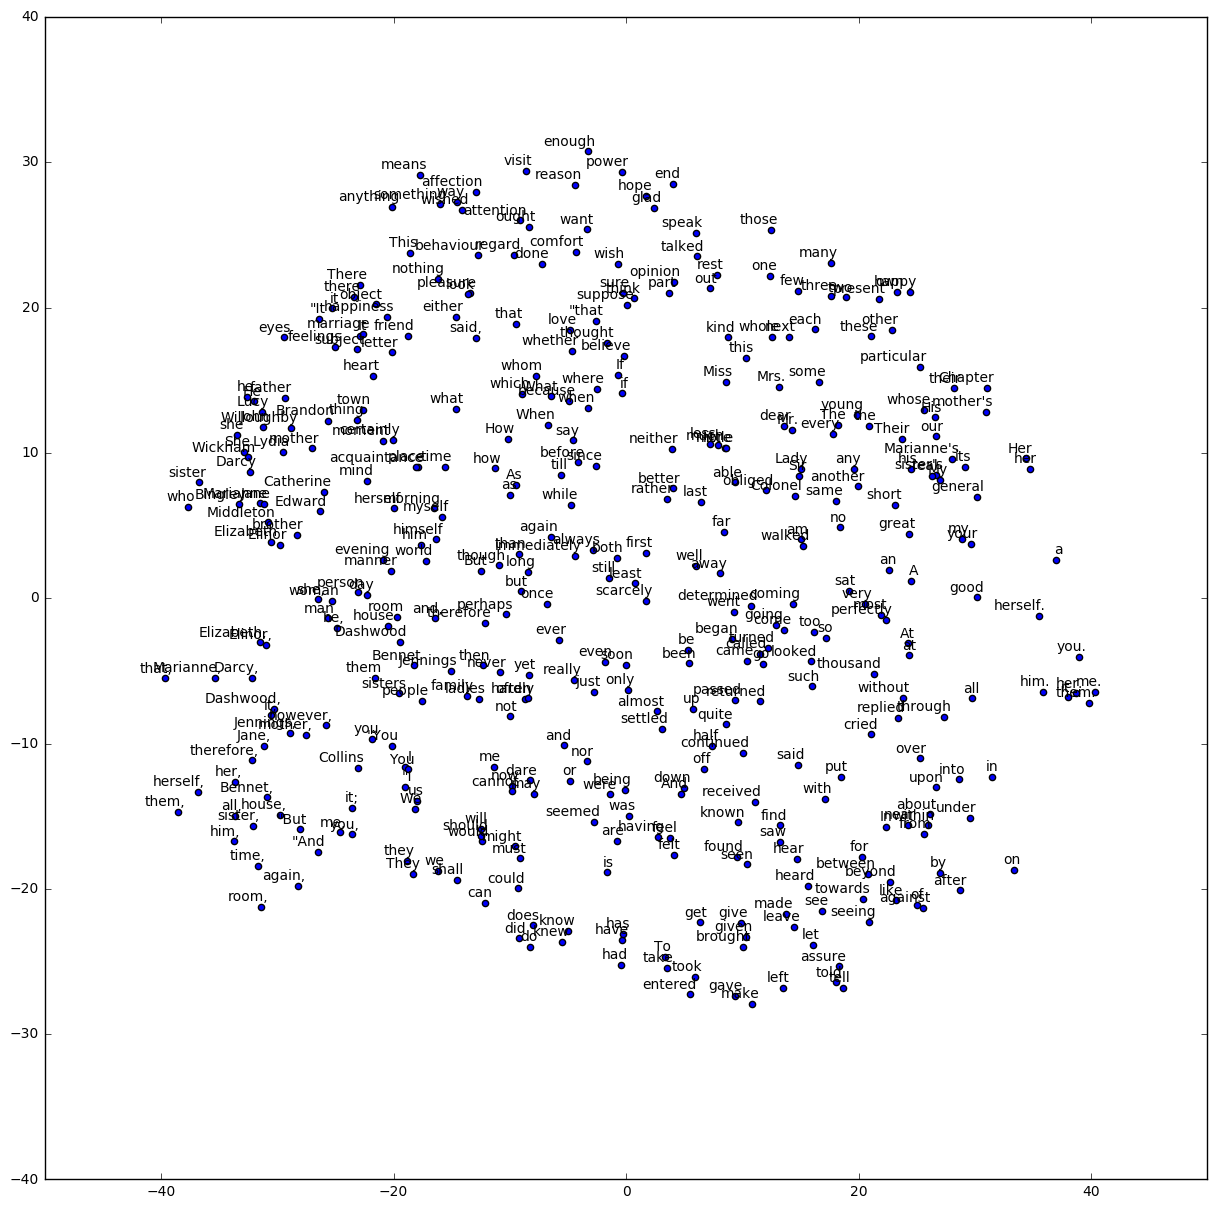

In [10]:
%matplotlib inline
from matplotlib import pylab
from sklearn.manifold import TSNE

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2),
                       textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

def draw(embeddings, reverse_dictionary):
    num_points = 400
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
    words = [reverse_dictionary[i] for i in range(1, num_points+1)]
    plot(two_d_embeddings, words)

reverse_dictionary = dict(zip(word_to_id.values(), word_to_id.keys())) 
draw(final_embeddings, reverse_dictionary)
#print(word_to_id)

In [12]:
num = 200
prime = "Elizabeth"
sampling_type=1

def sample():
    with open(os.path.join(save_dir, 'words_vocab.pkl'), 'rb') as f:
        words, vocab = cPickle.load(f)
    config.batch_size=1
    config.num_steps =1
    model = Model(is_training=False, config=config)
    with tf.Session() as session:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver(tf.all_variables())
        ckpt = tf.train.get_checkpoint_state(save_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print(model.sample(session, words, vocab, num, prime, sampling_type))
            
sample()

Elizabeth
Elizabeth would never have received, prevented her resolution was impatient to her while she believed that the whole equally justly lives. Mrs. Jennings, however, was particularly softened in one of the brilliant From her brother's and making a letter of remains to being informed that his two hours at vain. Do not oblige me for your father, I can then believe, though I am sure it will hardly tempt you to say, to Frosts on dining over it, I beg it but her aunt has interrupted this declaration; but that any period cannot be estimated too easily added to each other. I was less married; she opened before her father almost with a family of course or unforeseen from favourable, she would allow me the same; and I shall answer myself with the assurance which her sister explaining it. You will not be honest enough to accept what I recollect consequently after all; for on Lucy, of hearing that you could not continue the smallest preferment. I am the selfish part of his having ever ceas